# THCS #1
- generalization test

In [8]:
import warnings
warnings.filterwarnings("ignore")
import time
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append("..")
from redo_handy_utils import *
from redo_utils import *
from dl_utils import *

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [27]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

# tensorboard path
basepath = '/home/wengqy20/ML - work'
model_path = '06 - PINN/07 - code github/01 - Generalization'
log_path = '06 - PINN/07 - code github/01 - Generalization/tensorboard'
date_suf = 'THCS #1 - ' + datetime.now().strftime("%Y%m%d - %H%M%S")
writer = SummaryWriter(os.path.join(basepath, log_path,  date_suf))

## Network framework

In [10]:
# DNN
class DNN(torch.nn.Module):
    def __init__(self, layers):
        '''
        Args:
        layers  ::  array-like, number of neurons in each layer of the neural network
        
        '''
        super(DNN, self).__init__()
        # Network depth
        self.depth = len(layers) - 1
        
        # activation function
        # self.activation = torch.nn.ReLU
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        # hidden layer
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
        # output layer
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict).to(device)
        
    def forward(self, x):
        out = self.layers(x)
        return out

def initialize_net(net):
    net_name = net.__class__.__name__                               # 2
    if net_name.find('layer') != -1:                                              
        nn.init.xavier_normal_(net.weight)
        nn.init.xavier_normal_(net.bias)

In [11]:
# THCS
class THCS():
    def __init__(self, X_eq, U_eq, X_gap, U_gap, X_nw, T_nw, model, prop_net, **kargs):
        '''
        Args:
        X_eq     ::  2d array, coordinate of scarce samples used for label loss
        U_eq     ::  2d array, physical parameters of scarce samples used for label loss
        X_gap    ::  2d array, coordinate of scarce samples used for equation loss
        U_gap    ::  2d array, physical parameters of scarce samples used for equation loss
        X_nw     ::  2d array, coordinate of scarce samples used for wall-temperature loss
        T_nw     ::  2d array, temperature of scarce samples used for wall-temperature loss
        model    ::  pkl, THCS model
        prop_net ::  pkl, MLP for thermal property mapping
        
        '''
        
        self.X_eq = torch.tensor(X_eq, requires_grad=True).float().to(device)
        self.U_eq = torch.tensor(U_eq, requires_grad=True).float().to(device)
        self.X_gap = torch.tensor(X_gap, requires_grad=True).float().to(device)
        self.U_gap = torch.tensor(U_gap, requires_grad=True).float().to(device)
        self.X_nw = torch.tensor(X_nw, requires_grad=True).float().to(device)
        self.T_nw = torch.tensor(T_nw, requires_grad=True).float().to(device)
        self.dnn = model
        self.prop_net = prop_net
        self.lb_T = kargs['T_lb']  # lower bound for the input of property network
        self.ub_T = kargs['T_ub']  # upper bound for the input of property network
        self.prop_cof = kargs['prop_cof']  # coefficient for property network
        self.T_pc = kargs['Tpc']  # pseudo-critical temperature
        self.ub = torch.tensor(kargs['ub'], requires_grad=True).float().to(device)  # lower bound for the input of main network
        self.lb = torch.tensor(kargs['lb'], requires_grad=True).float().to(device)  # upper bound for the input of main network
        self.loss_weight = kargs['loss_weight']  # weights of loss function

        # mean values of thermal properties
        self.prop_mean = kargs['prop_mean']  
        self.D_m = self.prop_mean['D']
        self.M_m = self.prop_mean['M']
        self.k_m = self.prop_mean['k']
        self.Cp_m = self.prop_mean['Cp']

        self.u_eq = self.U_eq[:, 0:1]
        self.v_eq = self.U_eq[:, 1:2]
        self.T_eq = self.U_eq[:, 2:3]
        self.p_eq = self.U_eq[:, 7:8]
        self.data_0d = kargs['data_0d']
        self.fluid = 'CO2'

        # Dimensionless number
        self.T0 = self.data_0d.loc[0, 'T0']
        self.L0 = self.data_0d.loc[0, 'L0']
        self.U0 = self.data_0d.loc[0, 'U0']
        self.D0 = self.data_0d.loc[0, 'D0']
        self.M0 = self.data_0d.loc[0, 'M0']
        self.k0 = self.data_0d.loc[0, 'k0']
        self.Cp0 = self.data_0d.loc[0, 'Cp0']
        self.hpc = self.data_0d.loc[0, 'hpc'] /self.Cp0/self.T0
        self.prop_scl = [self.prop_cof[0]/self.D0, self.prop_cof[1]/self.M0, self.prop_cof[2]/self.k0, self.prop_cof[3]/self.Cp0/self.T0]  # scale factor for property network

        self.gx = -9.8  # upward flow
        self.Fr = self.U0**2 / (self.gx * self.L0)
        self.Re = self.D0 * self.U0 * self.L0 / self.M0
        self.Pr = self.M0 * self.Cp0 * self.k0
       
        self.iter = 0

    # physical field prediction by main network
    def net_pd(self, x, r):
        """
        Args:
        x   ::  array-like or float, dimensionless x-coordinate
        r   ::  array-like or float, dimensionless r-coordinate

        Return:
        u   ::  array-like or float, dimensionless streamwise velocity
        v   ::  array-like or float, dimensionless radial velocity
        p   ::  array-like or float, dimensionless hydraulic pressure
        T   ::  array-like or float, dimensionless Temperature

        """
        x_scl = 2.0*(x - self.lb[0])/(self.ub[0] - self.lb[0]) - 1.0
        r_scl = 2.0*(r - self.lb[1])/(self.ub[1] - self.lb[1]) - 1.0
        X_scl = torch.concat((x_scl, r_scl), dim=1)
        field = self.dnn(X_scl)
        u_d, v_d, p, T = field[:, 0:1], field[:, 1:2], field[:, 2:3], field[:, 3:4]
        # hard manner for no-slip condition
        u = (1-r)*u_d
        v = (1-r)*v_d
        return u, v, p, T

    # thermal property prediction by property network
    def prop_pd(self, T):
        """
        Args:
        T   ::  array-like or float, dimensionless temperature

        Return:
        D   ::  array-like or float, dimensionless density
        M   ::  array-like or float, dimensionless viscosity
        k   ::  array-like or float, dimensionless conductivity
        h   ::  array-like or float, dimensionless enthalpy

        """
        T_dim = self.T0 * T  # Dimensionalization
        T_scl = 2.0*(T_dim - self.lb_T)/(self.ub_T - self.lb_T) - 1.0
        prop_dim = self.prop_net(T_scl)
        D, M, k, h = self.prop_scl[0]*prop_dim[:, 0:1], self.prop_scl[1]*prop_dim[:, 1:2], self.prop_scl[2]*prop_dim[:, 2:3], self.prop_scl[3]*prop_dim[:, 3:4] - self.hpc
        
        return D, M, k, h
    
    # heat flux prediction
    def qw_pd(self, T, r):
        """
        Args:
        T   ::  array-like or float, dimensionless temperature
        r   ::  array-like or float, dimensionless r-coordinate

        Return:
        qw  ::  array-like or float, dimensionless heat flux

        """
        D, M, k, h = self.prop_pd(T)
        T_y = torch.autograd.grad(
            T, r, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        qw = k*T_y
        
        return qw

    # equation loss prediction
    def net_eq(self, x, r):
        """ 

        Thermal properties involved in equation losses are mean values in the whole domain.

        """

        u, v, p, T = self.net_pd(x, r)
        D, M, k, Cp = self.D_m, self.M_m, self.k_m, self.Cp_m 
        h = Cp*T

        Du_x = torch.autograd.grad(
            D*u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]
        Dv_r = torch.autograd.grad(
            D*v, r, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0]


        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]
        u_r = torch.autograd.grad(
            u, r, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]

        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0] 
        v_r = torch.autograd.grad(
            v, r, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0]

        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
            )[0]
        p_r = torch.autograd.grad(
            p, r, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
            )[0]


        divU = u_x + (v_r + v/r)  # divergence
        # shear stress 
        shear_xx = 2*(M) * (u_x - divU/3)
        shear_xr = (M) * (v_x + u_r)
        shear_rr = 2*(M) * (v_r - divU/3)
        shear_xx_x = torch.autograd.grad(
            shear_xx, x, 
            grad_outputs=torch.ones_like(shear_xx),
            retain_graph=True,
            create_graph=True
            )[0] 
        shear_xr_r = torch.autograd.grad(
            r*shear_xr, r, 
            grad_outputs=torch.ones_like(shear_xr),
            retain_graph=True,
            create_graph=True
            )[0]
        shear_rx_x = torch.autograd.grad(
            shear_xr, x, 
            grad_outputs=torch.ones_like(shear_xr),
            retain_graph=True,
            create_graph=True
            )[0]
        shear_rr_r = torch.autograd.grad(
            r*shear_rr, r, 
            grad_outputs=torch.ones_like(shear_rr),
            retain_graph=True,
            create_graph=True
            )[0]

        T_x = torch.autograd.grad(
            T, x, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        T_r = torch.autograd.grad(
            T, r, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        h_x = torch.autograd.grad(
            h, x, 
            grad_outputs=torch.ones_like(h),
            retain_graph=True,
            create_graph=True
            )[0]
        h_r = torch.autograd.grad(
            h, r, 
            grad_outputs=torch.ones_like(h),
            retain_graph=True,
            create_graph=True
            )[0]
        # heat flux
        q_x = k * T_x
        q_r = k * T_r
        q_xx = torch.autograd.grad(
            q_x, x, 
            grad_outputs=torch.ones_like(q_x),
            retain_graph=True,
            create_graph=True
            )[0]
        q_rr = torch.autograd.grad(
            r*q_r, r, 
            grad_outputs=torch.ones_like(q_r),
            retain_graph=True,
            create_graph=True
            )[0]

        eq_m = Du_x + (Dv_r + D*v/r)  # mass conservation
        eq_u = D*u*u_x + D*v*u_r + p_x - 1/self.Re * (shear_xx_x + shear_xr_r/r) - D/self.Fr  # momentum conservation at direction of x
        eq_v = D*u*v_x + D*v*v_r + p_r - 1/self.Re * (shear_rx_x + shear_rr_r/r - 2*M/r*(v/r - divU/3))  # momentum conservation at direction of r
        eq_T = D*u*h_x + D*v*h_r - 1/self.Re/self.Pr * (q_xx + q_rr/r)  # energy conservation
        return eq_m, eq_u, eq_v, eq_T

    def loss_cal(self):
        eq_m, eq_u, eq_v, eq_T = self.net_eq(self.X_gap[:, 0:1], self.X_gap[:, 1:2])  # equation loss
        r_qt = self.X_eq[:, 1:2]
        u_pred, v_pred, p_pred, T_pred = self.net_pd(self.X_eq[:, 0:1], r_qt)  # label loss
        u_pred_nw, v_pred_nw, p_pred_nw, T_pred_nw = self.net_pd(self.X_nw[:, 0:1], self.X_nw[:, 1:2])  # loss of wall temperature, not adopted here

        # loss weight
        l_eq_m, l_eq_u, l_eq_v, l_eq_T = self.loss_weight['loss_eq_m'], self.loss_weight['loss_eq_u'], self.loss_weight['loss_eq_v'], self.loss_weight['loss_eq_T']
        l_u_eq, l_v_eq, l_T_eq, l_p_eq = self.loss_weight['loss_u_eq'], self.loss_weight['loss_v_eq'], self.loss_weight['loss_T_eq'], self.loss_weight['loss_p_eq']
        l_T_nw = self.loss_weight['loss_T_nw']


        loss_eq_m = l_eq_m * torch.mean(eq_m**2)
        loss_eq_u = l_eq_u * torch.mean(eq_u**2)
        loss_eq_v = l_eq_v * torch.mean(eq_v**2)
        loss_eq_T = l_eq_T * torch.mean(eq_T**2)

        # when close to the Tpc, increase the weight
        idx_Tpc = (abs(self.T_eq - self.T_pc) < 0.03)
        weight_pc = 2
        loss_u_eq = l_u_eq * (torch.mean(((u_pred - self.u_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean(((u_pred - self.u_eq)[idx_Tpc]**2)))
        loss_v_eq = l_v_eq * (torch.mean((1e3*(v_pred - self.v_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean((1e3*(v_pred - self.v_eq)[idx_Tpc]**2)))
        loss_T_eq = l_T_eq * (torch.mean(((T_pred - self.T_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean(((T_pred - self.T_eq)[idx_Tpc]**2)))
        loss_p_eq = l_p_eq * (torch.mean((1e-2*(p_pred - self.p_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean((1e-2*(p_pred - self.p_eq)[idx_Tpc]**2)))
        loss_T_nw = l_T_nw * torch.mean((T_pred_nw - self.T_nw)**2)
        loss_u = loss_u_eq + loss_v_eq
        loss_p = loss_p_eq
        loss_T = loss_T_eq +  loss_T_nw
        loss_eq = loss_eq_m + loss_eq_u + loss_eq_v + loss_eq_T 
        loss = loss_u + loss_T + loss_eq + loss_p

        # record loss in tensorboard
        writer.add_scalar('Loss_eq_m', loss_eq_m, self.iter)
        writer.add_scalar('Loss_eq_u', loss_eq_u, self.iter)
        writer.add_scalar('Loss_eq_v', loss_eq_v, self.iter)
        writer.add_scalar('Loss_eq_T', loss_eq_T, self.iter)
        writer.add_scalar('Loss_T_eq', loss_T_eq, self.iter)
        writer.add_scalar('Loss_u_eq', loss_u_eq, self.iter)
        writer.add_scalar('Loss_v_eq', loss_v_eq, self.iter)
        writer.add_scalar('Loss_p_eq', loss_p_eq, self.iter)
        writer.add_scalar('Loss_T_nw', loss_T_nw, self.iter)
        writer.add_scalar('Loss_u', loss_u, self.iter)
        writer.add_scalar('Loss_T', loss_T, self.iter)
        writer.add_scalar('Loss_eq', loss_eq, self.iter)
        writer.add_scalar('Loss', loss, self.iter)

        # print loss
        self.iter += 1
        if self.iter % 50 == 0:
            print('Iteration %d: loss: %.2e' %(self.iter, loss))
            print('loss_eq_m: %.2e, loss_eq_u: %.2e, loss_eq_v: %.2e, loss_eq_T: %.2e' %(loss_eq_m, loss_eq_u, loss_eq_v, loss_eq_T))
            print('loss_u_eq: %.2e, loss_v_eq: %.2e, loss_T_eq: %.2e, loss_p_eq: %.2e, loss_T_nw: %.2e' %(loss_u_eq, loss_v_eq, loss_T_eq, loss_p_eq, loss_T_nw))

        return loss

    # model training
    def train(self, iterat, optimizer_Adam, min_lr, patience):
        self.optimizer_Adam = optimizer_Adam
        tic = time.time()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_Adam, factor=0.6, patience=patience, min_lr=min_lr)
        for i in range(iterat):
            loss = self.loss_cal()
            loss.backward() 
            self.optimizer_Adam.step()
            self.optimizer_Adam.zero_grad()
            scheduler.step(loss)
            writer.add_scalar('Learning rate', self.optimizer_Adam.state_dict()['param_groups'][0]['lr'], self.iter)

        toc = time.time()
        print('Adam training time: %.2fs' %(toc - tic))
        self.loss_epoch.append(float(self.iter))

        return

    # predict physical fields
    def predict(self, X):
        X = torch.tensor(X, requires_grad=True).float().to(device)
        x, r= X[:, 0:1], X[:, 1:2]
        self.dnn.eval()
        u, v, p, T = self.net_pd(x, r)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        T = T.detach().cpu().numpy()
        return u, v, p, T

    # predict thermal properties
    def predict_prop(self, T):
        """
        Args:
        T   ::  array-like or float, dimensionless Temperature

        Return:
        D   ::  array-like or float, dimensionless density
        M   ::  array-like or float, dimensionless viscosity
        k   ::  array-like or float, dimensionless conductivity
        h   ::  array-like or float, dimensionless enthalpy
        """

        T = torch.tensor(T, requires_grad=True).float().to(device)
        D, M, k, h = self.prop_pd(T)
        D = D.detach().cpu().numpy()
        M = M.detach().cpu().numpy()
        k = k.detach().cpu().numpy()
        h = h.detach().cpu().numpy()
        return D, M, k, h

    # predict heat flux 
    def predict_qw(self, X):
        X = torch.tensor(X, requires_grad=True).float().to(device)
        x, r= X[:, 0:1], X[:, 1:2]
        self.dnn.eval()
        u, v, p, T = self.net_pd(x, r)
        qw = self.qw_pd(T, r)
        qw = qw.detach().cpu().numpy()
        return qw

## Model training

### Thermal property prediction

In [12]:
layers_prop = [1, 20, 20, 20, 20, 20, 4]
prop_net = DNN(layers_prop)
prop_net.load_state_dict(torch.load(os.path.join(basepath, model_path, '04 - SCO2 Prop', 'Prop_6layers(20)_full_1130_7750kPa.pkl')))
Tlb = 200
Tub = 600

prop_cof = [1e2, 1e-5, 1e0, 1e6]

### Load data

In [13]:
# parameter for initialization
fluid = 'CO2'
Tpc = 306.3492698539708  # pseudo-critical temperature 
Tref = 800  
L0, T0, Re0, p_in = 0.5e-3, 296.15, 1770.0, 7.75e6
D0 = property_from_NIST('Dmass', T0, p_in, fluid)
Cp0 = property_from_NIST('Cpmass', T0, p_in, fluid)
M0 = property_from_NIST('viscosity', T0, p_in, fluid)
k0 = property_from_NIST('conductivity', T0, p_in, fluid)
U0 = Re0*M0/(D0*L0)
hpc = property_from_NIST('Hmass', Tpc, p_in, fluid)

In [14]:
idx = 0
data_path_dns = [
    '02 - data/DNS_data/CaoYuli/3_p7.75q78/3_p7.75q78.mat',
    ]

N_wc_dns = len(data_path_dns)
dns_data = pd.DataFrame()

data_2d_dns = {}
data_0d_dns, data_1d_dns = pd.DataFrame(), pd.DataFrame()
data_2d_wc = {}
# 读取数据
dns_temp = scipy.io.loadmat(os.path.join(basepath, data_path_dns[idx]))

r_dns = dns_temp['y'].reshape(-1)
y_dns = 1 - r_dns
x_dns = 2*dns_temp['x'].reshape(-1)

# clean data
del dns_temp['__header__'], dns_temp['__version__'], dns_temp['__globals__']  # 无用数据
del dns_temp['A'], dns_temp['a'], dns_temp['ans'], dns_temp['N1'], dns_temp['N2'], dns_temp['Nk'], dns_temp['NX'], dns_temp['NY'], dns_temp['R_IO'], dns_temp['ReN'], dns_temp['str'], dns_temp['time1'], dns_temp['time2']
del dns_temp['table'], dns_temp['temp'], dns_temp['data1'], dns_temp['data2'], dns_temp['data3'], dns_temp['data4'], dns_temp['dummy_flow'], dns_temp['dummy_thel'], dns_temp['dummy1_flow'], dns_temp['dummy1_thel'], dns_temp['dummy2_flow'], dns_temp['dummy2_thel'], dns_temp['dummyline'], dns_temp['fid1'], dns_temp['fid2'], dns_temp['fid3'], dns_temp['fid4'], dns_temp['fid5'], dns_temp['fid6'], dns_temp['fid7'], dns_temp['RLEMPI1_FLOW'], dns_temp['RLEMPI1_thel'], dns_temp['RLEMPI2_FLOW'], dns_temp['RLEMPI2_thel']
del dns_temp['i'], dns_temp['j'], dns_temp['k'], dns_temp['J'], dns_temp['y'], dns_temp['xx'], dns_temp['xND'], dns_temp['len']

# Classify variables with different dimension
data_0d_temp, data_1d_temp = pd.DataFrame(np.zeros(1)), pd.DataFrame(np.zeros(len(dns_temp['x'][0])))
for feat,data in dns_temp.items():
    # Scalar
    if data.shape[1] == 1:
        data_0d_temp[feat] = data[0][0]

    # 1d-array
    elif data.shape[0] == 1:
        data_1d_temp[feat] = data[0]
    
    # 2d-array
    elif len(data.shape) == 2:
        data_2d_wc[feat] = pd.DataFrame(data)
        data_2d_wc[feat].columns = r_dns

data_0d_temp['P0'] = p_in
data_0d_temp['Re0'] = Re0
data_0d_temp['U0'] = data_0d_temp['Re0'] * data_0d_temp['M0'] / data_0d_temp['D0'] / (2*data_0d_temp['L0'])
data_0d_temp['h0'] = property_from_NIST('Hmass', data_0d_temp.loc[0, 'T0'], data_0d_temp.loc[0, 'P0'], 'CO2')
data_0d_temp['hpc'] = property_from_NIST('Hmass', Tpc, data_0d_temp.loc[0, 'P0'], 'CO2')
data_0d_temp['href'] = property_from_NIST('Hmass', Tref, data_0d_temp.loc[0, 'P0'], 'CO2')
data_0d_temp.drop(columns=0, inplace=True)
data_1d_temp.drop(columns=0, inplace=True)
data_0d_temp['wc_idx'] = idx
data_1d_temp['wc_idx'] = idx

data_1d_temp.insert(0, 'x/r', 2*data_1d_temp['x'])
data_1d_temp.drop(columns='x', inplace=True)

data_0d_dns = pd.concat((data_0d_dns, data_0d_temp))
data_1d_dns = pd.concat((data_1d_dns, data_1d_temp))
data_2d_dns[idx] = data_2d_wc
    
data_0d_dns.reset_index(drop=True, inplace=True)
data_1d_dns.reset_index(drop=True, inplace=True)

In [18]:
# mean value of thermal properties
Tb_m = CP.PropsSI('T', 'Hmass', (data_1d_dns['Hb'] * (data_0d_dns.loc[0, 'T0']*data_0d_dns.loc[0, 'Cp0']) + data_0d_dns.loc[0, 'href']).values, 'P', np.ones(len(x_dns))*p_in, 'CO2').mean()
D_m = property_from_NIST('Dmass', Tb_m, p_in, fluid) / data_0d_dns.loc[0, 'D0']
M_m = property_from_NIST('viscosity', Tb_m, p_in, fluid) / data_0d_dns.loc[0, 'M0']
k_m = property_from_NIST('conductivity', Tb_m, p_in, fluid) / data_0d_dns.loc[0, 'k0']
Cp_m = property_from_NIST('Cpmass', Tb_m, p_in, fluid) / data_0d_dns.loc[0, 'Cp0']
prop_mean = {'D':D_m, 'M':M_m, 'k':k_m, 'Cp':Cp_m}

In [19]:
# 2d data
x_star_dns = data_1d_dns['x/r'].unique()[:, None]  # Nx x 1
r_star_dns = r_dns[:,None]  # Ny x 1
X_dns, R_dns = np.meshgrid(x_star_dns, r_star_dns, indexing='ij')  # Nx x Ny
X_star_dns = np.hstack((X_dns.flatten('F')[:,None], R_dns.flatten('F')[:,None]))  # NxNyNq x 3


data_2d_dns = data_2d_dns[idx]
u_dns = data_2d_dns['Ux_Re'].to_numpy()  # Nx x Ny
v_dns = data_2d_dns['Uy_Re'].to_numpy()  # Nx x Ny
p_dns = data_2d_dns['P_Re'].to_numpy()  # Nx x Ny
T_dns = data_2d_dns['T_Re'].to_numpy()  # Nx x Ny
D_dns = data_2d_dns['D_Re'].to_numpy()  # Nx x Ny
M_dns = data_2d_dns['M_Re'].to_numpy()  # Nx x Ny
k_dns = data_2d_dns['K_Re'].to_numpy()  # Nx x Ny
# the original temperature of enthalpy is 800K
h_dns = data_2d_dns['H_Re'].to_numpy() + (data_0d_dns.loc[0, 'href']-data_0d_dns.loc[0, 'hpc'])/(data_0d_dns.loc[0, 'T0']*data_0d_dns.loc[0, 'Cp0']) # Nx x Ny

u_star_dns = u_dns.flatten('F')[:,None]  # NxNyNq x 1
v_star_dns = v_dns.flatten('F')[:,None]  # NxNyNq x 1
p_star_dns = p_dns.flatten('F')[:,None]  # NxNyNq x 1
h_star_dns = h_dns.flatten('F')[:,None]  # NxNyNq x 1
T_star_dns = T_dns.flatten('F')[:,None]  # NxNyNq x 1
D_star_dns = D_dns.flatten('F')[:,None]  # NxNyNq x 1
M_star_dns = M_dns.flatten('F')[:,None]  # NxNyNq x 1
k_star_dns = k_dns.flatten('F')[:,None]  # NxNyNq x 1

U_star_dns = np.array([])
U_star_dns = np.hstack((u_star_dns, v_star_dns, T_star_dns, D_star_dns, M_star_dns, k_star_dns, h_star_dns, p_star_dns))  # NxNyNq x 9

In [20]:
# random seed
set_seed(1)

# training set
N_eq = 1000  # number of data for label loss
N_gap = 200  # number of data for equation loss
lb_dns = np.array([0.0, 0.0])  # lower bound for input coordinates
ub_dns = np.array([240.0, 1.0])  # upper bound for input coordinates

# for generalization test, data are only sampled in the range of [0,70)∪[140, 240]
gap = [70, 140]
X_eq_dns, U_eq_dns = np.array([]), np.array([])
X_train = X_star_dns[((X_star_dns[:, 0] < gap[0])|((X_star_dns[:, 0] >= gap[1])&(X_star_dns[:, 0] <= 236)))]
X_test = X_star_dns[(X_star_dns[:, 0] >= gap[0])&(X_star_dns[:, 0] < gap[1])]
U_train = U_star_dns[((X_star_dns[:, 0] < gap[0])|(X_star_dns[:, 0] >= gap[1])&(X_star_dns[:, 0] <= 236))]
U_test = U_star_dns[(X_star_dns[:, 0] >= gap[0])&(X_star_dns[:, 0] < gap[1])]

# For more uniform sampling, 30% data are in the near-wall region (r >= 0.8)
wall_bd = 0.8
test_pc = 0.3
X_core_train = X_train[((X_train[:, 1] < wall_bd))]
X_wall_train = X_train[(X_train[:, 1] >= wall_bd)]
U_core_train = U_train[((X_train[:, 1] < wall_bd))]
U_wall_train = U_train[(X_train[:, 1] >= wall_bd)]
idx_eq_core = np.random.choice(X_core_train.shape[0], int(N_eq*(1-test_pc)), replace=False)
idx_eq_wall = np.random.choice(X_wall_train.shape[0], int(N_eq*test_pc), replace=False)
X_eq_dns = np.vstack((X_core_train[idx_eq_core], X_wall_train[idx_eq_wall]))
U_eq_dns = np.vstack((U_core_train[idx_eq_core], U_wall_train[idx_eq_wall]))

X_core_test = X_train[((X_train[:, 1] < wall_bd))]
X_wall_test = X_train[(X_train[:, 1] >= wall_bd)]
U_core_test = U_train[((X_train[:, 1] < wall_bd))]
U_wall_test = U_train[(X_train[:, 1] >= wall_bd)]
idx_eq_core = np.random.choice(X_core_test.shape[0], int(N_gap*(1-test_pc)), replace=False)
idx_eq_wall = np.random.choice(X_wall_test.shape[0], int(N_gap*test_pc), replace=False)
X_gap_dns = np.vstack((X_core_test[idx_eq_core], X_wall_test[idx_eq_wall]))
U_gap_dns = np.vstack((U_core_test[idx_eq_core], U_wall_test[idx_eq_wall]))


# wall temperature sampling
## N_nw is the number of data sampled in the direction of r
## N_b is the number of data sampled in the direction of x
N_nw, N_b = 1, 10 
n_gap = x_dns[(x_dns >= gap[0])&(x_dns < gap[1])].shape[0]
idx_b = np.array([int(x) for x in np.linspace(0, n_gap, N_b)]) + x_dns[(x_dns < gap[0])].shape[0]  # uniform distribution
for j in range(N_b):
    X_temp = X_star_dns[(X_star_dns[:, 0]==x_dns[idx_b[j]])&(X_star_dns[:, 1]>=r_dns[-N_nw])]
    T_temp = U_star_dns[(X_star_dns[:, 0]==x_dns[idx_b[j]])&(X_star_dns[:, 1]>=r_dns[-N_nw]), 2][:,None]
    if j == 0:
        X_nw_dns = X_temp
        T_nw_dns = T_temp
    else:
        X_nw_dns = np.vstack((X_nw_dns, X_temp))
        T_nw_dns = np.vstack((T_nw_dns, T_temp))

###  Network construction

In [45]:
# NN size
layers = [2, 36, 36, 36, 36, 36, 36, 36, 4]
dnn = DNN(layers)

# Initialize or load the model
LOADMODEL = True
# LOADMODEL = False
if LOADMODEL:
    dnn.load_state_dict(torch.load(os.path.join(basepath, model_path, '10layers(36)_THCS#1 Generalization.pkl')))
else:
    dnn.apply(initialize_net)

In [46]:
optimizer_Adam = optim.Adam(dnn.parameters(), lr=1e-3)
loss_weight = {
    'loss_eq_m':1e4, 'loss_eq_u':1e4, 'loss_eq_v':1e3, 'loss_eq_T':1e6, 
    'loss_u_ub':1e0, 'loss_v_ub':1e0, 'loss_T_ub':1e0,
    'loss_u_lb':1e0, 'loss_v_lb':1e0, 'loss_T_lb':1e0,
    'loss_u_0':1e0, 'loss_v_0':1e0, 'loss_T_0':1e0,
    'loss_u_eq':1e5, 'loss_v_eq':1e4, 'loss_T_eq':1e7, 'loss_p_eq':0, 'loss_T_nw':0,
    }
thcs = THCS(X_eq_dns, U_eq_dns, X_gap_dns, U_gap_dns, X_nw_dns, T_nw_dns, dnn, prop_net, lb=lb_dns, ub=ub_dns, loss_weight=loss_weight, data_0d=data_0d_dns, T_lb=Tlb, T_ub=Tub, prop_cof=prop_cof, Tpc=Tpc/T0, prop_mean=prop_mean)

### Model training

In [ ]:
num_epochs = 46000
thcs.train(num_epochs, optim.Adam(dnn.parameters(), lr=0.72e-4), min_lr=0.2e-4, patience=1000)

In [ ]:
# model saving
# torch.save(dnn.state_dict(), os.path.join(basepath, model_path, '10layers(36)_THCS#1 Generalization.pkl'))

## Visualization

In [47]:
data_2d_wc = {}
feats_keys = {'Ux_Re':'u', 'Uy_Re':'v', 'P_Re':'p', 'T_Re':'T', 'D_Re':'D', 'M_Re':'M', 'K_Re':'k', 'H_Re':'h'}
for k,v in feats_keys.items():
    data_2d_wc[v] = data_2d_dns[k]
    
u = data_2d_wc['u'].to_numpy()  # Nx x Ny
v = data_2d_wc['v'].to_numpy()  # Nx x Ny
p = data_2d_wc['p'].to_numpy()  # Nx x Ny
T = data_2d_wc['T'].to_numpy()  # Nx x Ny
D = data_2d_wc['D'].to_numpy()  # Nx x Ny
M = data_2d_wc['M'].to_numpy()  # Nx x Ny
k = data_2d_wc['k'].to_numpy()  # Nx x Ny
h = data_2d_wc['h'].to_numpy()  # Nx x Ny

# Prediction for visualization
X_star_draw = X_star_dns[X_star_dns[:, 0]<236, :]
u_pred, v_pred, p_pred, T_pred= thcs.predict(X_star_draw)
D_pred, M_pred, k_pred, h_pred = thcs.predict_prop(T_pred)
uu_pred = griddata(X_star_draw[:,:2], u_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
vv_pred = griddata(X_star_draw[:,:2], v_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
TT_pred = griddata(X_star_draw[:,:2], T_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
DD_pred = griddata(X_star_draw[:,:2], D_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
MM_pred = griddata(X_star_draw[:,:2], M_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
kk_pred = griddata(X_star_draw[:,:2], k_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
hh_pred = griddata(X_star_draw[:,:2], h_pred.flatten(), (X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :]), method='cubic')
e_T = abs((TT_pred - T[X_dns[:,0]<236, :])/T[X_dns[:,0]<236, :]).mean()*100
e_u = abs((uu_pred - u[X_dns[:,0]<236, :])/u[X_dns[:,0]<236, :]).mean()*100
e_v = abs((vv_pred - v[X_dns[:,0]<236, :])/v[X_dns[:,0]<236, :]).mean()*100
l_T = (abs(TT_pred - T[X_dns[:,0]<236, :])).mean()
l_u = (abs(uu_pred - u[X_dns[:,0]<236, :])).mean()
l_v = (abs(vv_pred - v[X_dns[:,0]<236, :])).mean()
print('Relative error: error_u = %.2f%%, error_v = %.2f%%,  error_T = %.2f%%' %(e_u, e_v, e_T))
print('Loss: Loss_u = %.2e, Loss_v = %.2e,  Loss_T = %.2e' %(l_u, l_v, l_T))

Relative error: error_u = 1.88%, error_v = 1055.48%,  error_T = 0.34%
Loss: Loss_u = 1.43e-02, Loss_v = 6.51e-04,  Loss_T = 4.19e-03


In [36]:
def plot_heatmap_pcolor(X, Y, Z, vmin=0, vmax=1, figsize=(9, 5), barlim=[], cmap=None, feats=['$x$', '$y$', '$z$'], SHOWFIG=True, POINTDRAW=False, TITLE=True, LEFT=True, BOTTOM=False, BAR=True, contour=0, **POINT):
    '''
    Args:
    X        ::  2d array, x coordinate
    Y        ::  2d array, r coordinate
    Z        ::  2d array, values of the drawn variable
    vmin     ::  float, the min value of the drawn variable
    vmax     ::  float, the max value of the drawn variable
    figsize  ::  tuple, figure size
    cmap     ::  str, cmap for field
    feats    ::  list, names of variables
    TITLE    ::  bool, whether show the title
    SHOWFIG  ::  bool, whether show the picture
    POINTDRAW::  bool, whether draw scatter points
    LEFT     ::  bool, whether show the left r coordinate
    BOTTOM   ::  bool, whether show the bottom x coordinate
    BAR      ::  bool, whether show the color bar
    '''
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    # Draw Points
    if POINTDRAW:
        X_eq = POINT['X_eq']
        X_bd = POINT['X_bd']
        if len(X_eq) > 0:
            ax.plot(X_eq[:,0], X_eq[:,1], POINT['shape_eq'], c=POINT['color_eq'], label='Equation Data (%d points)' % (X_eq.shape[0]), markersize=4, clip_on=False)
        if len(X_bd) > 0:
            ax.plot(X_bd[:,0], X_bd[:,1], POINT['shape_bd'], c=POINT['color_bd'], label='Boundary Data (%d points)' % (X_bd.shape[0]), markersize=4, clip_on=False)
    z_fig = ax.pcolormesh(X, Y, Z, cmap=cmap,
                vmin=vmin, vmax=vmax)
    if contour != 0:
        a = ax.contour(X, Y, Z, levels=[contour], lw=2, linestyles='-.', colors='tab:red')
        plt.clabel(a, inline=True, fontsize=20)

    ax.set_ylim(r_dns.min(),r_dns.max())
    ax.vlines(70,0,1, ls='--', colors='tab:red')
    ax.vlines(140,0,1, ls='--', colors='tab:red')

    if LEFT:
        ax.set_ylabel(feats[1], size=44, labelpad=0.8)
        ax.set_yticks([0, 0.5, 1])

    else:
        if BAR:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.10)
            cbar = fig.colorbar(z_fig, cax=cax)
            cbar.ax.tick_params(labelsize=40) 
            cbar.ax.ticklabel_format(axis='y', style='plain', useMathText=True, scilimits=(barlim[0], barlim[-1]))
            cbar.ax.set_yticks(barlim)
        ax.set_yticks([])

    if BOTTOM:
        ax.set_xlabel(feats[0], size=44, labelpad=0.8)
        ax.set_xticks([0, 118, 236])
        # ax.tick_params(axis='x', pad=10)
    
    else:
        ax.set_xticks([])


    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.9, -0.05), 
        ncol=5, 
        frameon=False, 
        prop={'size': 15}
    )
    if TITLE:
        ax.set_title(feats[2], fontsize = 28) # font size doubled
    ax.tick_params(labelsize=40)


    if SHOWFIG:
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


u: 0.2637925010454203
v: 0.045205586547603635
T: 0.06753097376963524


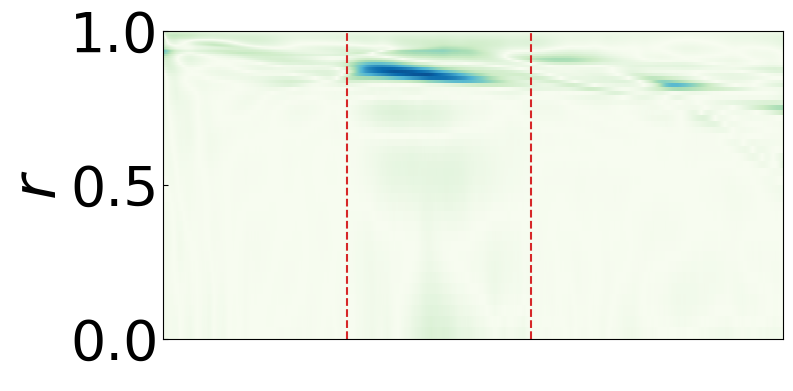

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


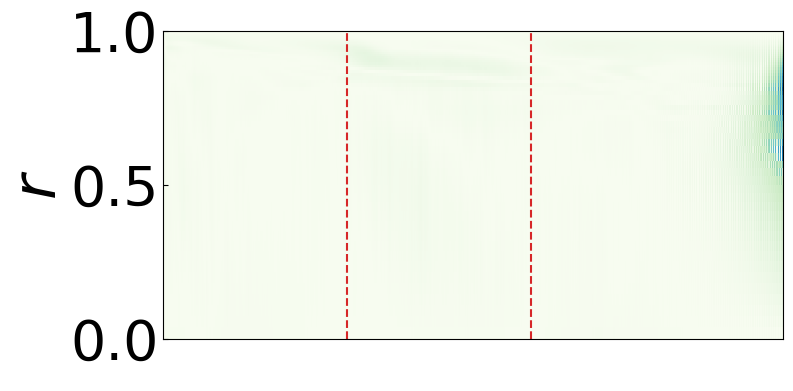

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


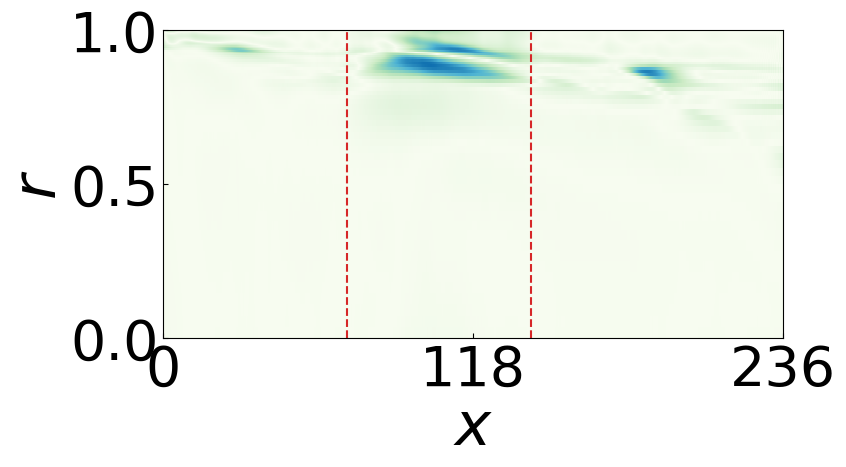

In [37]:
print('u:', abs(u[X_dns[:,0]<236, :] - uu_pred).max())
print('v:', abs(v[X_dns[:,0]<236, :] - vv_pred).max())
print('T:', abs(T[X_dns[:,0]<236, :] - TT_pred).max())
plot_heatmap_pcolor(X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :], abs(u[X_dns[:,0]<236, :] - uu_pred), vmax=0.28, vmin=0, figsize=(8, 4), TITLE=False, VLIMIT=True, feats=['$x$', '$r$'], cmap='GnBu', barlim=[0, 0.14, 0.28], LEFT=True, BAR=False)

plot_heatmap_pcolor(X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :], abs(v[X_dns[:,0]<236, :] - vv_pred), vmax=0.05, vmin=0, figsize=(8, 4), TITLE=False, VLIMIT=True, feats=['$x$', '$r$'], cmap='GnBu', barlim=[0, 0.025, 0.05], LEFT=True, BAR=False)

plot_heatmap_pcolor(X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :], abs(T[X_dns[:,0]<236, :] - TT_pred), vmax=0.08, vmin=0, figsize=(8, 4), TITLE=False, VLIMIT=True, feats=['$x$', '$r$'], cmap='GnBu', barlim=[0, 0.04, 0.08], BOTTOM=True, LEFT=True, BAR=False)

Text(0, 0.5, '$r$')

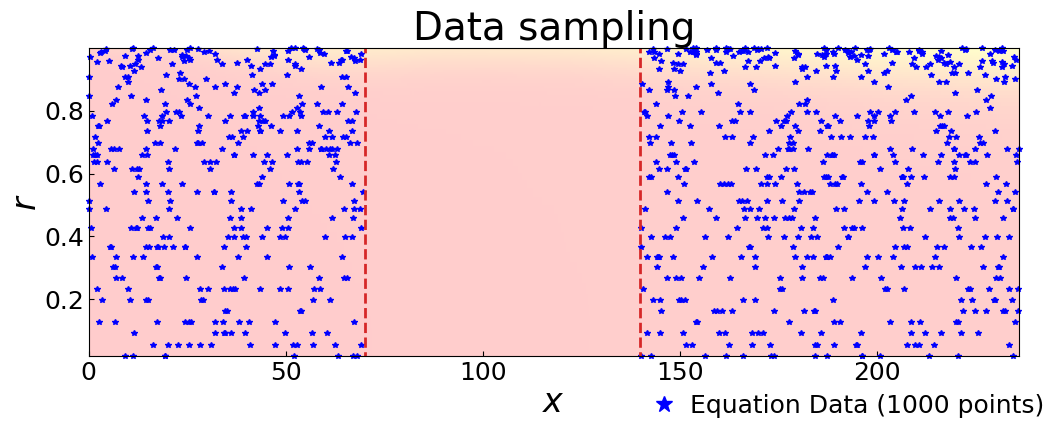

In [44]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
xlim = [x_star_dns.min(), x_star_dns[(X_dns[:,0]<236)].max()]
ylim = [r_star_dns.min(), r_star_dns.max()]
ax.plot(X_eq_dns[:,0], X_eq_dns[:,1], '*', c='blue', label='Equation Data (%d points)' % (X_eq_dns.shape[0]), markersize=4, clip_on=False)
z_fig = ax.pcolormesh(X_dns[X_dns[:,0]<236, :], R_dns[X_dns[:,0]<236, :], T[X_dns[:,0]<236, :],  cmap='autumn', alpha=0.2)  #aspect控制轴的纵横比

feats=['$x$', '$r$', 'Data sampling']
ax.set_ylim(r_dns.min(),r_dns.max())
ax.set_xlabel(feats[0], size=24, labelpad=0.8)
ax.set_ylabel(feats[1], size=24, labelpad=0.8)
ax.vlines(70,0,1, ls='--', colors='tab:red', lw=2)
ax.vlines(140,0,1, ls='--', colors='tab:red', lw=2)

ax.set_title(feats[2], fontsize = 28) # font size doubled
ax.tick_params(labelsize=18)

ax.legend(loc='upper center', bbox_to_anchor=(0.82, -0.05), ncol=5, frameon=False, prop={'size': 18}, handlelength=0.5, markerscale=3)
ax.set_ylim(r_dns.min(),r_dns.max())
ax.set_xlabel(feats[0], size=24, labelpad=0.8)
ax.set_ylabel(feats[1], size=24, labelpad=0.8)
